In [109]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reinforcement Learning Trading Bot


## Import Data for TESLA ticker

In [110]:
tesla = yf.Ticker("TSLA")

tesla_data = tesla.history(period='5y')

df = pd.DataFrame(tesla_data)

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-11 00:00:00-05:00,23.458668,23.812668,23.406000,23.513332,103467000,0.0,0.0
2019-12-12 00:00:00-05:00,23.661333,24.182667,23.548668,23.978666,116458500,0.0,0.0
2019-12-13 00:00:00-05:00,24.070000,24.347334,23.642668,23.892668,98563500,0.0,0.0
2019-12-16 00:00:00-05:00,24.170000,25.573999,24.166668,25.433332,272613000,0.0,0.0
2019-12-17 00:00:00-05:00,25.266001,25.700001,25.059999,25.266001,127452000,0.0,0.0


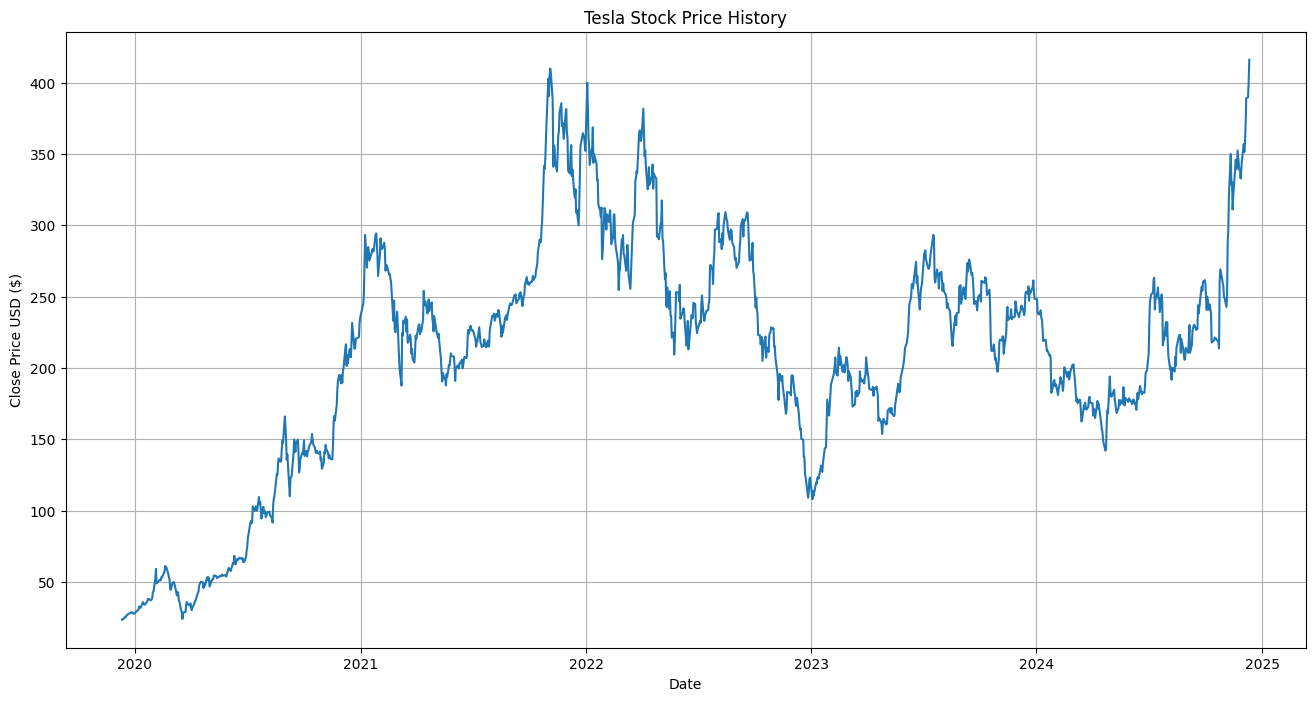

In [111]:
plt.figure(figsize=(16,8))
plt.title('Tesla Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot( df.Close)
plt.grid(True)
plt.show()

## Add some features to the data
- Price Change
- Moving Average
- Volatility
- RSI
- Volume features


In [112]:

def rolling_mean(df, window=20):
    df['rolling_mean'] = df['Close'].rolling(window=window, min_periods=1).mean()
    return df

def pct_change(df):
    df['pct_change'] = df['Close'].pct_change()
    df.bfill(inplace=True)
    return df


def volatility(df, window=20):

    returns = df['Close'].pct_change()
    returns.bfill(inplace=True)

    df['volatility'] = returns.rolling(window=window, min_periods=1).std()
    df['volatility'] = df['volatility'].bfill()
    return df

def process_data(df):
    df = rolling_mean(df)
    df = volatility(df)
    df = pct_change(df)
    return df

df = process_data(df)

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean,volatility,pct_change
Date,,,,,,,,,,
2019-12-11 00:00:00-05:00,23.458668,23.812668,23.406000,23.513332,103467000,0.0,0.0,23.513332,0.000000,0.019790
2019-12-12 00:00:00-05:00,23.661333,24.182667,23.548668,23.978666,116458500,0.0,0.0,23.745999,0.000000,0.019790
2019-12-13 00:00:00-05:00,24.070000,24.347334,23.642668,23.892668,98563500,0.0,0.0,23.794889,0.013497,-0.003586
2019-12-16 00:00:00-05:00,24.170000,25.573999,24.166668,25.433332,272613000,0.0,0.0,24.204500,0.028462,0.064483
2019-12-17 00:00:00-05:00,25.266001,25.700001,25.059999,25.266001,127452000,0.0,0.0,24.416800,0.028435,-0.006579


# Basic RL QLearning setup

In [113]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [114]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        
        self.df = df
        self.initial_balance = initial_balance
        
        # Create a more balanced action space:
        # Actions structured as: [position_change, position_size]
        # position_change: -1 (sell), 0 (hold), 1 (buy)
        # position_size: 0.0 to 1.0 in steps of 0.25
        self.action_space = spaces.MultiDiscrete([3, 4])  # [3 actions, 4 size levels]
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.position = 0  # No position
        self.balance = self.initial_balance  # Initial balance
        self.done = False
        self.shares_held = 0
        return self._get_observation()
    
    def _get_observation(self):
        # Implement your feature engineering here
        obs = np.array([
            self.position,
            self.df.iloc[self.current_step]['Close'],
            self.df.iloc[self.current_step]['Volume'],
            self.df.iloc[self.current_step]['rolling_mean'],
            self.df.iloc[self.current_step]['volatility'],
            self.df.iloc[self.current_step]['pct_change'],
            # Add your technical indicators here
        ])
        return obs
    
    def step(self, action):
        # Store initial portfolio value for reward calculation
        initial_portfolio_value = self.balance + (self.shares_held * self.df.iloc[self.current_step]['Close'])
        
        position_change, size_level = action
        position_size = size_level * 0.25
        
        current_price = self.df.iloc[self.current_step]['Close']
        
        # Calculate price change
        price_change = 0
        if self.current_step > 0:
            price_change = (current_price - self.df.iloc[self.current_step-1]['Close']) / self.df.iloc[self.current_step-1]['Close']
        
        # Apply trading costs
        transaction_cost = 0.001  # 0.1% trading fee
        
        # Track old position for reward calculation
        old_shares_held = self.shares_held
        # max_shares = self.balance // current_price
        
        if position_change == 1:  # Buy
            max_shares = self.balance // current_price
            shares_to_buy = int(max_shares * position_size)
            cost = shares_to_buy * current_price * (1 + transaction_cost)
            if cost <= self.balance:
                self.balance -= cost
                self.shares_held += shares_to_buy
                
        elif position_change == -1:  # Sell
            shares_to_sell = int(self.shares_held * position_size)
            self.balance += shares_to_sell * current_price * (1 - transaction_cost)
            self.shares_held -= shares_to_sell
        
        # Move to next timestep
        self.current_step += 1
        
        # Calculate reward components
        final_portfolio_value = self.balance + (self.shares_held * current_price)
        
        # Portfolio return component
        portfolio_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
        
        # Position alignment component (reward for being in the right position)
        # position_reward = 0
        # if price_change > 0.01:  # Strong upward trend
        #     position_reward = self.shares_held / max_shares  # Reward for holding during uptrend
        # elif price_change < -0.01:  # Strong downward trend
        #     position_reward = (max_shares - self.shares_held) / max_shares  # Reward for not holding during downtrend
        
        # Trading activity component (small reward for taking action to prevent always holding)
        trading_reward = 0
        if position_change != 0 and abs(old_shares_held - self.shares_held) > 0:
            trading_reward = 0.001
        
        # Combine reward components
        reward = portfolio_return + 0.1 + trading_reward
        
        # Check if episode is done
        self.done = self.current_step >= len(self.df) - 1

        if self.current_step < 5:
            print(f"Step: {self.current_step}, Reward: {reward:.2f}, Portfolio Value: {final_portfolio_value:.2f}, Shares Held: {self.shares_held}, Balance: {self.balance:.2f}")
            print(f"Action: {action}")
        
        return self._get_observation(), reward, self.done, {
            'portfolio_value': final_portfolio_value,
            'shares_held': self.shares_held,
            'balance': self.balance
        }

In [115]:
# DQN Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [116]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [117]:
import random
from collections import deque
import torch.nn.functional as F

class DQNAgent:
    def __init__(self, state_size, action_size, env, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.env = env
        self.device = device
        self.memory = ReplayBuffer(100000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.learning_rate = 0.001

        # Get the dimensions of the action space
        self.n_positions = env.action_space.nvec[0]  # Number of position changes (3: buy/hold/sell)
        self.n_sizes = env.action_space.nvec[1]      # Number of size levels (4: 0.25, 0.5, 0.75, 1.0)

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def act(self, state):
        if random.random() <= self.epsilon:
            # Generate random action as tuple
            position = np.random.randint(0, self.n_positions)
            size = np.random.randint(0, self.n_sizes)
            return (position, size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            action_idx = q_values.max(1)[1].item()
            
            # Convert flat action index back to tuple
            position = action_idx // self.n_sizes
            size = action_idx % self.n_sizes
            return (position, size)

    def _flatten_action(self, action):
        # Convert action tuple to flat index for neural network
        position, size = action
        return position * self.n_sizes + size

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.FloatTensor(batch[0]).to(self.device)
        # Convert action tuples to flat indices
        action_batch = torch.LongTensor([self._flatten_action(a) for a in batch[1]]).to(self.device)
        reward_batch = torch.FloatTensor(batch[2]).to(self.device)
        next_state_batch = torch.FloatTensor(batch[3]).to(self.device)
        done_batch = torch.FloatTensor(batch[4]).to(self.device)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))

        loss = F.smooth_l1_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training loop
def train_agent(env, agent, episodes=1000):
    rewards_history = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            agent.train()
            
            state = next_state
            total_reward += reward
            
        rewards_history.append(total_reward)
        
        if episode % 10 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
            # Update target network
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    return rewards_history

# Run training
env = StockTradingEnv(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.nvec.prod()  # Total number of possible actions
agent = DQNAgent(state_size, action_size, env)  # Pass env to agent

rewards = train_agent(env, agent)

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

Episode: 0, Total Reward: 125.81, Epsilon: 0.01
Episode: 10, Total Reward: 125.82, Epsilon: 0.01
Episode: 20, Total Reward: 125.82, Epsilon: 0.01


In [ ]:
def evaluate_agent(env, agent, episodes=10):
    total_rewards = []
    portfolio_values = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = agent.act(state)  # During evaluation, we don't need epsilon-greedy
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            portfolio_values.append(info['portfolio_value'])
        
        total_rewards.append(episode_reward)
        
    return np.mean(total_rewards), portfolio_values

# Evaluate the trained agent
mean_reward, portfolio_history = evaluate_agent(env, agent)
print(f"Mean evaluation reward: {mean_reward:.2f}")

# Plot portfolio value over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_history)
plt.title('Portfolio Value During Evaluation')
plt.xlabel('Trading Step')
plt.ylabel('Portfolio Value ($)')
plt.show()